In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import praw
import datetime as dt
import requests
import numpy as np
import pytz
import time
import yfinance as yf




# Convert from date to unix and unix to date

In [2]:
def convert_to_unix(date):
  unixd = dt.datetime.strptime(date,"%Y-%m-%d")
  return time.mktime(unixd.timetuple())

  
def convert_to_date(timestamp):
  return str(dt.datetime.fromtimestamp(int(timestamp)).date())

In [3]:
print(convert_to_unix('2020-02-20'))

1582128000.0


# Use pushshift api to retrieve reddit data

In [4]:
query = "bitcoin"
subreddit="bitcoin" #Define Your subreddit
after="2d"
before = "1d"
fields = "title,created_utc"
sort_type = "created_utc" #score, num_comments, default=created_utc
def get_data(query,
            subreddit,
            before,
            after,
            fields,
            size,
            sort_type):
    url = f"https://api.pushshift.io/reddit/search/submission/?q={query}&before={before}&after={after}&subreddit={subreddit}&fields={fields}&size={size}&sort_type={sort_type}"
    request = requests.get(url)
    json_response = request.json()
    return json_response['data']

def multiple_data_call(lookback_period:int,
                **kwargs):
        df = pd.DataFrame(columns = ['date','reddit_title'])
        for i in range(1,lookback_period+1):
                try:
                        after = str(i+1)+'d'
                        before = str(i)+'d'
                        response=get_data(query,subreddit,before,after,fields,size,sort_type)
                        titles = []
                        date = []         
                        for line in response:
                                date.append(convert_to_date(line['created_utc']))
                                titles.append(line['title'])
                        temp = pd.DataFrame(np.column_stack([date,titles]),columns = ['date','reddit_title'])
                        df = pd.concat([df,temp])
                except:
                        print(f"Error encountered for {convert_to_date(line['created_utc'])}")
                        continue
        df.index = list(range(len(df)))
        return df
                


[*********************100%***********************]  1 of 1 completed
BTCUSD price


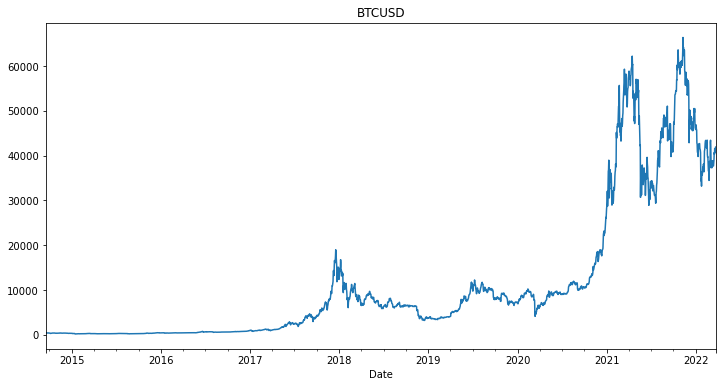

In [5]:
tickerlist = ['BTC-USD']
df = yf.download(tickerlist, period = '1d', start = '2007-01-01',end = pd.Timestamp.today())
columns = df.columns
df = df.iloc[:,2]['2007':]
df.plot(figsize = (12,6),title = 'BTCUSD')
print('BTCUSD price')

# Calculate rolling 7-day return 

In [6]:
pct_change = pd.DataFrame(df.pct_change(periods = 7).fillna(method = 'bfill'))
pct_change.columns = ['pcnt_change']
pct_change['date'] = pct_change.index.astype(str)
pct_change['index'] = range(len(pct_change))
pct_change.set_index('index',drop = True,inplace = True)
pct_change

,pcnt_change,date
index,,
0,-0.069161,2014-09-17
1,-0.069161,2014-09-18
2,-0.069161,2014-09-19
3,-0.069161,2014-09-20
4,-0.069161,2014-09-21
...,...,...
2740,0.072993,2022-03-19
2741,0.086848,2022-03-20
2742,0.079279,2022-03-21


In [69]:
query = "bitcoin"
subreddit="bitcoin" #Define Your Query
fields = "title,created_utc"
size = 10
sort_type = "score" #score, num_comments, default=created_utc
data = multiple_data_call(lookback_period=380,
            query = query,
            subreddit=subreddit,
            fields=fields,
            sort_type=sort_type)
data

Error encountered for 2022-01-02


,date,reddit_title
0,2022-03-22,I have found a new and easy way to make some b...
1,2022-03-22,DOGECOIN IS BETTER THAN BITCOIN BITCOIN BAD AN...
2,2022-03-22,Whenever you swap some fiat for bitcoin
3,2022-03-22,US SEC proposes companies disclose range of cl...
4,2022-03-22,UFC Fighter Matheus Nicolau Becomes the First-...
...,...,...
3665,2021-03-08,Bitcoin has a Xinjiang problem
3666,2021-03-08,With hindsight my happiest day in Bitcoin was ...
3667,2021-03-08,Who is paying people to mine? (Where does the ...
3668,2021-03-08,Norwegian Multinational Aker ASA to Invest in ...


In [108]:
cleanedata1 = pd.DataFrame(data.groupby(['date'])['reddit_title'].apply(lambda x:','.join(x)))


In [137]:
merged_data = cleanedata1.merge(pct_change, on='date',how = 'left')
merged_data['class'] = [0 if x<0 else 1 for x in merged_data.pcnt_change]
merged_data.to_csv('dataset_merged.csv')

In [138]:
merged_data

,date,reddit_title,pcnt_change,class
0,2021-03-08,looing to spend a lot of money in bit coin (1m...,0.097328,1
1,2021-03-09,Happy Women's Day to all the ladies who hodl b...,0.100637,1
2,2021-03-10,"The Case for $70k Bitcoin by April,Loans that ...",0.103918,1
3,2021-03-11,"When crash?,Price could drop to 40K before it ...",0.143267,1
4,2021-03-12,Are you demoralized for having less than 0.01 ...,0.189808,1
...,...,...,...,...
362,2022-03-18,"You already missed the bus with bitcoin, don’t...",0.050980,1
363,2022-03-19,"More Than $500,000 In Bitcoin Stolen From A Co...",0.072993,1
364,2022-03-20,La guerra es el óptimo examen de Bitcoin/crypt...,0.086848,1
365,2022-03-21,"Bitcoin to 10 million dollars,Bitcoin and cryp...",0.079279,1


# Natural Language Processing with NLTK

In [139]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder #Convert text into numerical form
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [140]:
#Convert to lower case
merged_data['reddit_title'] = merged_data['reddit_title'].str.strip().str.lower()


In [141]:
from nltk.tokenize import sent_tokenize, word_tokenize #import the sentence and word tokenizer
import nltk
#Punkt Sentence Tokenizer. This tokenizer divides a text into a list of sentences, by using an unsupervised algorithm 
#to build a model for abbreviation words, collocations, and words that start sentences.
##Download the punkit
nltk.download('punkt') 
merged_data['reddit_title'] = list(map(word_tokenize,merged_data['reddit_title']))
merged_data

[nltk_data] Downloading package punkt to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,date,reddit_title,pcnt_change,class
0,2021-03-08,"[looing, to, spend, a, lot, of, money, in, bit...",0.097328,1
1,2021-03-09,"[happy, women, 's, day, to, all, the, ladies, ...",0.100637,1
2,2021-03-10,"[the, case, for, $, 70k, bitcoin, by, april, ,...",0.103918,1
3,2021-03-11,"[when, crash, ?, ,, price, could, drop, to, 40...",0.143267,1
4,2021-03-12,"[are, you, demoralized, for, having, less, tha...",0.189808,1
...,...,...,...,...
362,2022-03-18,"[you, already, missed, the, bus, with, bitcoin...",0.050980,1
363,2022-03-19,"[more, than, $, 500,000, in, bitcoin, stolen, ...",0.072993,1
364,2022-03-20,"[la, guerra, es, el, óptimo, examen, de, bitco...",0.086848,1
365,2022-03-21,"[bitcoin, to, 10, million, dollars, ,, bitcoin...",0.079279,1


In [142]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_stopwords(sentence_list:list):
    wordlist = [word for word in sentence_list if word in stopwords.words('english')]
    return wordlist
merged_data['reddit_title'] = list(map(remove_stopwords,merged_data['reddit_title']))
merged_data
    


[nltk_data] Downloading package stopwords to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,reddit_title,pcnt_change,class
0,2021-03-08,"[to, a, of, in, but, do, to, and, to, it, as, ...",0.097328,1
1,2021-03-09,"[to, all, the, who, few, and, some, was, the, ...",0.100637,1
2,2021-03-10,"[the, for, by, that, i, can, as, we, to, from,...",0.103918,1
3,2021-03-11,"[when, to, before, it, how, can, in, if, it, t...",0.143267,1
4,2021-03-12,"[are, you, for, having, than, at, the, has, no...",0.189808,1
...,...,...,...,...
362,2022-03-18,"[you, the, with, don, t, on, these, is, to, an...",0.050980,1
363,2022-03-19,"[more, than, in, from, a, is, and, by, the, on...",0.072993,1
364,2022-03-20,"[so, it, s, not, his, of, the, was, too, and, ...",0.086848,1
365,2022-03-21,"[to, and, it, is, to, in, which, you, has, whi...",0.079279,1


In [143]:
from nltk.stem.porter import PorterStemmer 
#We will use porter stemming method
# There is also other types of stemming such as lancaster stemming
port = PorterStemmer()
def stem_words(wordlist:list):
    stemmed_w_list = [port.stem(word) for word in wordlist]
    return stemmed_w_list
merged_data['reddit_title'] = list(map(stem_words,merged_data['reddit_title']))
merged_data

,date,reddit_title,pcnt_change,class
0,2021-03-08,"[to, a, of, in, but, do, to, and, to, it, as, ...",0.097328,1
1,2021-03-09,"[to, all, the, who, few, and, some, wa, the, a...",0.100637,1
2,2021-03-10,"[the, for, by, that, i, can, as, we, to, from,...",0.103918,1
3,2021-03-11,"[when, to, befor, it, how, can, in, if, it, th...",0.143267,1
4,2021-03-12,"[are, you, for, have, than, at, the, ha, not, ...",0.189808,1
...,...,...,...,...
362,2022-03-18,"[you, the, with, don, t, on, these, is, to, an...",0.050980,1
363,2022-03-19,"[more, than, in, from, a, is, and, by, the, on...",0.072993,1
364,2022-03-20,"[so, it, s, not, hi, of, the, wa, too, and, to...",0.086848,1
365,2022-03-21,"[to, and, it, is, to, in, which, you, ha, whic...",0.079279,1


In [144]:
from nltk.stem.wordnet import WordNetLemmatizer
wnet = WordNetLemmatizer()
nltk.download('wordnet')#Download wordnet
def lem_words(wordlist:list):
    lemmed_w_list = [wnet.lemmatize(word) for word in wordlist]
    return lemmed_w_list

merged_data['reddit_title'] = list(map(lem_words,merged_data['reddit_title']))
merged_data


[nltk_data] Downloading package wordnet to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,date,reddit_title,pcnt_change,class
0,2021-03-08,"[to, a, of, in, but, do, to, and, to, it, a, a...",0.097328,1
1,2021-03-09,"[to, all, the, who, few, and, some, wa, the, a...",0.100637,1
2,2021-03-10,"[the, for, by, that, i, can, a, we, to, from, ...",0.103918,1
3,2021-03-11,"[when, to, befor, it, how, can, in, if, it, th...",0.143267,1
4,2021-03-12,"[are, you, for, have, than, at, the, ha, not, ...",0.189808,1
...,...,...,...,...
362,2022-03-18,"[you, the, with, don, t, on, these, is, to, an...",0.050980,1
363,2022-03-19,"[more, than, in, from, a, is, and, by, the, on...",0.072993,1
364,2022-03-20,"[so, it, s, not, hi, of, the, wa, too, and, to...",0.086848,1
365,2022-03-21,"[to, and, it, is, to, in, which, you, ha, whic...",0.079279,1


In [148]:
def to_string(wlist:list):
    strng = ' '.join([str(item) for item in wlist])
    return strng
for i in merged_data.index:
    merged_data.loc[i,'reddit_title'] = to_string(merged_data.loc[i,'reddit_title'])
merged_data

,date,reddit_title,pcnt_change,class
0,2021-03-08,to a of in but do to and to it a a by in wa ho...,0.097328,1
1,2021-03-09,to all the who few and some wa the a the can c...,0.100637,1
2,2021-03-10,the for by that i can a we to from the if you ...,0.103918,1
3,2021-03-11,when to befor it how can in if it the from a i...,0.143267,1
4,2021-03-12,are you for have than at the ha not onli me it...,0.189808,1
...,...,...,...,...
362,2022-03-18,you the with don t on these is to and on all i...,0.050980,1
363,2022-03-19,more than in from a is and by the on in ha in ...,0.072993,1
364,2022-03-20,so it s not hi of the wa too and too into how ...,0.086848,1
365,2022-03-21,to and it is to in which you ha which wa the a...,0.079279,1


In [149]:
X = merged_data['reddit_title']
Y = merged_data['class']
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

In [150]:
x_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0]], dtype=int64)

In [152]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [153]:
model.score(x_test, y_test)

0.43243243243243246

# Natural Language Processing with Pyspark (Failed)

In [11]:
# PySpark applications start with initializing SparkSession which is the entry point of PySpark as below
import os
os.environ["JAVA_HOME"] = "C:/Progra~1/Java/jdk1.8.0_321"

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()


In [12]:
proc_data = merged_data[['class','reddit_title']]
proc_data.columns = ['label','reddit_title']
proc_data

,label,reddit_title
0,1,"Bitcoin to the moon,looing to spend a lot of m..."
1,1,Happy Women's Day to all the ladies who hodl b...
2,1,"The Case for $70k Bitcoin by April,Loans that ..."
3,1,Sovereign Wealth Funds Are Ready to Buy Bitcoi...
4,1,Keiser Report: Jonathan Chester CEO of Bitwage...
...,...,...
363,1,My Biggest Regret (story and advice from a sil...
364,1,"March 19, 2013: Bitcoin and me (Hal Finney),Mo..."
365,1,Apple co-founder explaining #Bitcoin not crypt...
366,1,A Progressive View of Bitcoin with Margot Paez...


In [13]:
df = spark.createDataFrame(proc_data)
df.show(10)

+-----+--------------------+
|label|        reddit_title|
+-----+--------------------+
|    1|Bitcoin to the mo...|
|    1|Happy Women's Day...|
|    1|The Case for $70k...|
|    1|Sovereign Wealth ...|
|    1|Keiser Report: Jo...|
|    1|Website that i ca...|
|    1|When Will All Of ...|
|    1|QUESTION about in...|
|    1|Bitcoin as piggy ...|
|    1|BTC,Not sending B...|
+-----+--------------------+
only showing top 10 rows



In [14]:
#Tokenizer
from pyspark.ml.feature import Tokenizer, RegexTokenizer,StopWordsRemover,CountVectorizer,VectorAssembler
from pyspark.sql.functions import col,udf
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import NaiveBayes


In [15]:
stages = []

regexTok = RegexTokenizer(inputCol='reddit_title',outputCol = 'tokenized_titles',pattern = "\\W")
stages+=[regexTok]

remover = StopWordsRemover(inputCol = 'tokenized_titles',outputCol = 'tokremd_titles')
stages +=[remover]

cv = CountVectorizer(inputCol='tokremd_titles',outputCol = 'data_features')
stages+=[cv]

vecAssembler = VectorAssembler(inputCols=['data_features'],outputCol="features")
stages+=[vecAssembler]

In [16]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
data = pipeline.fit(df).transform(df)

In [17]:
data.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|        reddit_title|    tokenized_titles|      tokremd_titles|       data_features|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1|Bitcoin to the mo...|[bitcoin, to, the...|[bitcoin, moon, l...|(6114,[0,12,18,25...|(6114,[0,12,18,25...|
|    1|Happy Women's Day...|[happy, women, s,...|[happy, women, da...|(6114,[0,1,2,7,9,...|(6114,[0,1,2,7,9,...|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [25]:
dfnew = data.toPandas()
dfnew = dfnew[['label','features']]
dfnew

,label,features
0,1,"(7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,"(8.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,1,"(10.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0,..."
3,1,"(12.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,..."
4,1,"(6.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...
363,1,"(9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
364,1,"(9.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, ..."
365,1,"(7.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
366,1,"(9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
X = dfnew[['features']]
Y = dfnew['label']

In [29]:
#Split data into train and test
x_train,x_test, y_train,y_test = train_test_split(X,Y,test_size = 0.20, random_state = 42)

In [30]:
## Posterior Probability
### Going to need likelihood and prior probability

#For prior probability
def prior_probability(y_train, label):
    #label refers to x and 0 values
    m = y.shape[0]
    s= np.sum(y_train == label)
    return m/s

def cond_probability(x_train,y_train, feature_col, feature_val, label):
    
    x_filtered = x_train[y_train == label]
    num = np.sum(x_filtered[:,feature_col]==feature_val)
    
    denom = x_filtered.shape[0]
    return float(num/denom)

def predict(x_train,y_train,x_test):
    classes = np.unique(y_train)
    n_features = x_train.shape[1]
    
    posterior_prob = []
    for label in classes:
        likelihood = 1.0 #initialise a mf value
        for fea in range(n_features):
            #go through each feature column
            cond = cond_probability(x_train,y_train,fea, x_test[fea],label)
            likelihood = likelihood*cond
            
        prior = prior_probability(y_train,label) #find prior probabiity by calling the prior prob function
        post = likelihood * prior
        
        posterior_prob.append(post)
        
        pred = np.argmax(posterior_prob)
        
        return pred
    
def accuracy(x_train,y_train,x_test,y_test):
    pred = []
    for i in range(x_test.shape[0]):
        p = predict(x_train,y_train,x_test[i])
        pred.append(p)
    y_pred = np.array(pred)
    acc= np.sum(y_pred==y_test)/y_test.shape[0] #Compare predicted value with value we alr know accurate prediction/actual
    
    return acc

In [31]:
acc = accuracy(x_train,y_train,x_test,y_test)

KeyError: 0

In [18]:
train, test = data.randomSplit([0.7, 0.3], seed = 2)
from pyspark.ml.classification import NaiveBayes
# Initialise the model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
# Fit the model
model = nb.fit(train)
# Make predictions on test data
predictions = model.transform(test)
predictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       1.0|[0.05284979934518...|
|    0|       0.0|[0.92050844526483...|
|    0|       1.0|[0.00195356909158...|
|    1|       1.0|[0.02105633070022...|
|    1|       1.0|[0.39960354989059...|
|    1|       0.0|[0.99974417517645...|
|    1|       0.0|[0.95143222605546...|
|    1|       1.0|[0.04209346228278...|
|    1|       0.0|[0.66674946084089...|
|    1|       1.0|[1.65364046508820...|
|    1|       0.0|[0.59930542439513...|
|    1|       1.0|[0.45687719690929...|
|    1|       1.0|[0.46675487186268...|
|    0|       1.0|[0.03369314453907...|
|    0|       0.0|[0.99969332327233...|
|    0|       1.0|[0.32405154502906...|
|    0|       0.0|[0.96418574325924...|
|    0|       1.0|[0.00110827150997...|
|    0|       1.0|[0.48200266705006...|
|    0|       0.0|[0.50337907757583...|
+-----+----------+--------------------+
only showing top 20 rows



In [19]:
predictions.select("label","prediction","reddit_title").show(20)

+-----+----------+--------------------+
|label|prediction|        reddit_title|
+-----+----------+--------------------+
|    0|       1.0|Bitcoin/Crypto Po...|
|    0|       0.0|How it feels to H...|
|    0|       1.0|Will a lot change...|
|    1|       1.0|Apple is investin...|
|    1|       1.0|Bitcoin to the mo...|
|    1|       0.0|Is Bitcoin the on...|
|    1|       0.0|Microsoft ION's D...|
|    1|       1.0|New to Bitcoin --...|
|    1|       0.0|Possible Unpopula...|
|    1|       1.0|Seed Phrase?,You ...|
|    1|       0.0|There wont be ano...|
|    1|       1.0|Website that i ca...|
|    1|       1.0|Why is the crypto...|
|    0|       1.0|Bitcoin 1 million...|
|    0|       0.0|Bitcoin BUY Signa...|
|    0|       1.0|Bitcoin,Elon Musk...|
|    0|       0.0|Do I have to pay ...|
|    0|       1.0|EV start-up Fiske...|
|    0|       1.0|How To Protect Yo...|
|    0|       0.0|How can i access ...|
+-----+----------+--------------------+
only showing top 20 rows



In [20]:
print(predictions.select("label","prediction","reddit_title").show(20))

+-----+----------+--------------------+
|label|prediction|        reddit_title|
+-----+----------+--------------------+
|    0|       1.0|Bitcoin/Crypto Po...|
|    0|       0.0|How it feels to H...|
|    0|       1.0|Will a lot change...|
|    1|       1.0|Apple is investin...|
|    1|       1.0|Bitcoin to the mo...|
|    1|       0.0|Is Bitcoin the on...|
|    1|       0.0|Microsoft ION's D...|
|    1|       1.0|New to Bitcoin --...|
|    1|       0.0|Possible Unpopula...|
|    1|       1.0|Seed Phrase?,You ...|
|    1|       0.0|There wont be ano...|
|    1|       1.0|Website that i ca...|
|    1|       1.0|Why is the crypto...|
|    0|       1.0|Bitcoin 1 million...|
|    0|       0.0|Bitcoin BUY Signa...|
|    0|       1.0|Bitcoin,Elon Musk...|
|    0|       0.0|Do I have to pay ...|
|    0|       1.0|EV start-up Fiske...|
|    0|       1.0|How To Protect Yo...|
|    0|       0.0|How can i access ...|
+-----+----------+--------------------+
only showing top 20 rows

None


# Testing Model Accuracy

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy*100,"%")

Model Accuracy:  54.754901960784316 %


# Workings

In [22]:
toked.show(2)

NameError: name 'toked' is not defined

# Remove stopwords


In [ ]:
remover = StopWordsRemover(inputCol = 'tokenized_titles',outputCol = 'tokremd_titles')
raw_words = remover.transform(toked)

In [ ]:
raw_words.show(3)

+----------+--------------------+-------------------+-----+--------------------+--------------------+
|      date|        reddit_title|        pcnt_change|class|    tokenized_titles|      tokremd_titles|
+----------+--------------------+-------------------+-----+--------------------+--------------------+
|2021-03-07|Bought some bitco...|0.13128700703731044|    1|[bought, some, bi...|[bought, bitcoin....|
|2021-03-08|Bitcoin to the mo...| 0.0973279798958635|    1|[bitcoin, to, the...|[bitcoin, moon,lo...|
|2021-03-09|Happy Women's Day...|0.10063740510797503|    1|[happy, women's, ...|[happy, women's, ...|
+----------+--------------------+-------------------+-----+--------------------+--------------------+
only showing top 3 rows



In [ ]:
cv= CountVectorizer(inputCol='tokremd_titles',outputCol = 'features')
model = cv.fit(raw_words)
countvectorizer_features = model.transform(raw_words)

In [ ]:
countvectorizer_features.show(2)

+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
|      date|        reddit_title|        pcnt_change|class|    tokenized_titles|      tokremd_titles|            features|
+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
|2021-03-07|Bought some bitco...|0.13128700703731044|    1|[bought, some, bi...|[bought, bitcoin....|(10324,[16,26,61,...|
|2021-03-08|Bitcoin to the mo...| 0.0973279798958635|    1|[bitcoin, to, the...|[bitcoin, moon,lo...|(10324,[0,1,15,30...|
+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
df.select("class").show(2)

+-----+
|class|
+-----+
|    1|
|    1|
+-----+
only showing top 2 rows



# Workings 2

In [ ]:
titles = []
date = []
for data in json_response['data']:
    date.append(convert_to_date(data['created_utc']))
    titles.append(data['title'])
df = pd.DataFrame(titles, index = date,columns = ['reddit_title'])
df

NameError: name 'json_response' is not defined

In [ ]:
list1 = [1,2,3,4]
list2= map(lambda x:x*2,list1)
list(list2)

[2, 4, 6, 8]

<AxesSubplot:title={'center':'BTCUSD'}, xlabel='Date'>

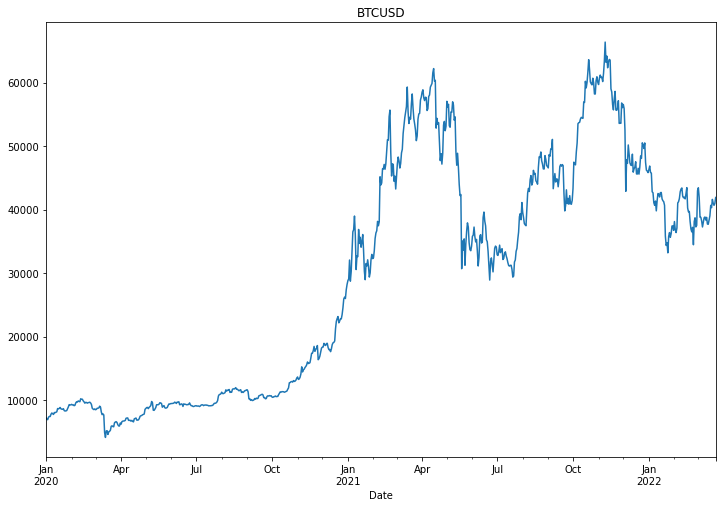

In [ ]:
df.plot(figsize = (12,8),title = 'BTCUSD')

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare training documents, which are labeled.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0),
    (4, "b spark who", 1.0),
    (5, "g d a y", 0.0),
    (6, "spark fly", 1.0),
    (7, "was mapreduce", 0.0),
    (8, "e spark program", 1.0),
    (9, "a e c l", 0.0),
    (10, "spark compile", 1.0),
    (11, "hadoop software", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

# Prepare test documents, which are unlabeled.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "mapreduce spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    print(row)

Row(id=4, text='spark i j k', probability=DenseVector([0.2661, 0.7339]), prediction=1.0)
Row(id=5, text='l m n', probability=DenseVector([0.9209, 0.0791]), prediction=0.0)
Row(id=6, text='mapreduce spark', probability=DenseVector([0.4429, 0.5571]), prediction=1.0)
Row(id=7, text='apache hadoop', probability=DenseVector([0.8584, 0.1416]), prediction=0.0)
